# EECS 498-007/598-005 Assignment 4-1: Pytorch Autograd and NN

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

# [torch.autograd](https://pytorch.org/docs/stable/autograd.html) and [torch.nn](https://pytorch.org/docs/stable/nn.html)

So far, we used PyTorch to accelarate computation using GPU.
PyTorch also provides several useful packages, which help to design deep neural networks efficiently.

The `torch.autograd` package provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.

This notebook assumes that you are using **PyTorch version 1.3 or above**.
In some of the previous versions (e.g. before 0.4), Tensors had to be wrapped in `torch.autograd.Variable` objects to enable autograd;
however this class has now been deprecated and merged with `torch.Tensor`.
In addition 1.0 also separates a Tensor's datatype from its device, and uses numpy-style factories for constructing Tensors rather than directly invoking Tensor constructors.
Now, to obtain gradients for a tensor via autograd from arbitrary scalar valued functions, you can simply set `requires_grad=True`.

The `torch.nn` package defines a set of Modules, which you can think of as a neural network layer that has produces output from input and may have some trainable weights.

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here.
If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better.

1. Part I, Preparation: As we always do, we will use CIFAR-10 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors with autograd.
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define an arbitrary neural network architecture. 
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a fully-connected and convolutional network very conveniently. 
5. Part V, Residual Network: please implement your own ResNet to get a high accuracy on CIFAR-10.

Here is a table of comparison:

| API             | Flexibility | Convenience |
|-----------------|-------------|-------------|
| Barebone        | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['eecs598', 'network_visualization.py', 'style_transfer.py',  'network_visualization.ipynb', 'a4_helper.py', 'pytorch_autograd_and_nn.py', 'pytorch_autograd_and_nn.ipynb', 'style_transfer.ipynb', 'rnn_lstm_attention_captioning.ipynb',  'rnn_lstm_attention_captioning.py']
```

In [5]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
#GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
#GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
#print(os.listdir(GOOGLE_DRIVE_PATH))
print(os.listdir('../A4'))

['rnn_lstm_attention_captioning.ipynb', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.py', 'style_transfer.ipynb', 'eecs598', 'style_transfer.py', '.ipynb_checkpoints', 'network_visualization.ipynb', 'a4_helper.py', 'network_visualization.py', 'rnn_lstm_attention_captioning.py', '__pycache__']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from pytorch_autograd_and_nn.py!
```

as well as the last edit time for the file `pytorch_autograd_and_nn.py`.

In [58]:
import sys
#sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
#time.tzset()

from pytorch_autograd_and_nn import *
from a4_helper import *
hello()

#py_path = os.path.join('pytorch_autograd_and_nn.py')
#py_edit_time = time.ctime(os.path.getmtime(py_path))
#print('pytorch_autograd_and_nn.py last edited on %s' % py_edit_time)

Hello from pytorch_autograd_and_nn.py!


In [51]:
import importlib
%load_ext autoreload
%autoreload 1
%aimport pytorch_autograd_and_nn
importlib.reload(pytorch_autograd_and_nn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'pytorch_autograd_and_nn' from '/home/dawn/文档/Assignment_of_EECS598/A4/pytorch_autograd_and_nn.py'>

### Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from eecs598.utils import reset_seed
from collections import OrderedDict

# for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

We will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

We will be using `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [4]:
to_float= torch.float
to_long = torch.long

#if torch.cuda.is_available:
#  print('Good to go!')
#else:
#  print('Please set GPU via Edit -> Notebook Settings.')

### Load CIFAR
Firstly, we will load the CIFAR-10 dataset. The utility function `load_CIFAR()` in `a4_helper` returns training, validaton and testing dataloaders for CIFAR-10 dataset. We are using [torchvision.datasets.CIFAR10](https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=cifar#torchvision.datasets.CIFAR10) to download the CIFAR-10 dataset.

In [5]:
loader_train, loader_val, loader_test = load_CIFAR(path='./datasets/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely, if `x` is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of `x` with respect to the scalar loss at the end.

### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [14]:
def two_layer_fc(x, params):
  """
  A fully-connected neural networks; the architecture is:
  NN is fully connected -> ReLU -> fully connected layer.
  Note that this function only defines the forward pass; 
  PyTorch will take care of the backward pass for us.
  
  The input to the network will be a minibatch of data, of shape
  (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
  and the output layer will produce scores for C classes.
  
  Inputs:
  - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
    input data.
  - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
    w1 has shape (H, D) and w2 has shape (C, H).
  
  Returns:
  - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
    the input data x.
  """
  # first we flatten the image
  x = flatten(x)  # shape: [batch_size, C x H x W]
  
  w1, b1, w2, b2 = params
  
  # Forward pass: compute predicted y using operations on Tensors. Since w1 and
  # w2 have requires_grad=True, operations involving these Tensors will cause
  # PyTorch to build a computational graph, allowing automatic computation of
  # gradients. Since we are no longer implementing the backward pass by hand we
  # don't need to keep references to intermediate values.
  # Note that F.linear(x, w, b) is equivalent to x.mm(w.t()) + b
  # For ReLU, you can also use `.clamp(min=0)`, equivalent to `F.relu()`
  x = F.relu(F.linear(x, w1, b1))
  x = F.linear(x, w2, b2)
  return x
    

def two_layer_fc_test():
  hidden_layer_size = 42
  x = torch.zeros((64, 3, 16, 16), dtype=to_float)  # minibatch size 64, feature dimension 3*16*16
  w1 = torch.zeros((hidden_layer_size, 3*16*16), dtype=to_float)
  b1 = torch.zeros((hidden_layer_size,), dtype=to_float)
  w2 = torch.zeros((10, hidden_layer_size), dtype=to_float)
  b2 = torch.zeros((10,), dtype=to_float)
  scores = two_layer_fc(x, [w1, b1, w2, b2])
  print('Output size:', list(scores.size()))  # you should see [64, 10]

two_layer_fc_test()

Output size: [64, 10]


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `kernel_size_1 x kernel_size_1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `kernel_size_2 x kernel_size_2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**HINT**: For convolutions: https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters! You can use `print(tensor.shape)` for debugging the shapes after each intemidiate layer.

Implement `three_layer_convnet` and run the cell below to test it. When you run this function, scores should have shape (64, 10).

In [22]:
def three_layer_convnet_test():
  x = torch.zeros((64, 3, 32, 32), dtype=to_float)  # minibatch size 64, image size [3, 32, 32]

  conv_w1 = torch.zeros((6, 3, 5, 5), dtype=to_float)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b1 = torch.zeros((6,))  # out_channel
  conv_w2 = torch.zeros((9, 6, 3, 3), dtype=to_float)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b2 = torch.zeros((9,))  # out_channel

  # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
  fc_w = torch.zeros((10, 9 * 32 * 32))
  fc_b = torch.zeros(10)

  # YOUR_TURN: Impelement the three_layer_convnet function
  scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
  print('Output size:', list(scores.size()))  # you should see [64, 10]
three_layer_convnet_test()

Output size: [64, 10]


### Barebones PyTorch: Kaiming Initialization
In this part, we are going to use [Kaiming initialization](https://arxiv.org/abs/1502.01852), which you already implemented in Assignment 3.

Fortunately, PyTorch already provides a function, so we will use this:
[torch.nn.init.kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

By default, `gain = 2`, because this function assumes that ReLU activation follows.
This is true in the linear and convolutional layers in the models you are going to implement, except for the last fully-connected layer:
in principle, we should give `gain = 1` because ReLU is not applied there.
However, as stated in the [original paper](https://arxiv.org/abs/1502.01852), since the factor 1/2 does not matter if it just exists on one layer, we are going to keep using `gain = 2` for simplicity.

For more details on initialization methods provided by PyTorch, see https://pytorch.org/docs/stable/nn.init.html.

In [23]:
reset_seed(0)

# create a weight of shape [3 x 5]
print(nn.init.kaiming_normal_(torch.empty(3, 5, dtype=to_float, device='cpu')))
print(nn.init.zeros_(torch.empty(3 ,5, dtype=to_float, device='cpu')))

tensor([[ 0.9746, -0.1856, -1.3780,  0.3595, -0.6859],
        [-0.8845,  0.2551,  0.5300, -0.4549, -0.2551],
        [-0.3773,  0.1151, -0.5418,  0.6961, -0.6775]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [28]:
def check_accuracy_part2(loader, model_fn, params):
  """
  Check the accuracy of a classification model.
  
  Inputs:
  - loader: A DataLoader for the data split we want to check
  - model_fn: A function that performs the forward pass of the model,
    with the signature scores = model_fn(x, params)
  - params: List of PyTorch Tensors giving parameters of the model
  
  Returns: Nothing, but prints the accuracy of the model
  """
  split = 'val' if loader.dataset.train else 'test'
  print('Checking accuracy on the %s set' % split)
  num_correct, num_samples = 0, 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device='cpu', dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device='cpu', dtype=to_long)
      scores = model_fn(x, params)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.nn.functional.cross_entropy` to compute the loss; you can [read about it here](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [35]:
def train_part2(model_fn, params, learning_rate):
  """
  Train a model on CIFAR-10.
  
  Inputs:
  - model_fn: A Python function that performs the forward pass of the model.
    It should have the signature scores = model_fn(x, params) where x is a
    PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
    model weights, and scores is a PyTorch Tensor of shape (N, C) giving
    scores for the elements in x.
  - params: List of PyTorch Tensors giving weights for the model
  - learning_rate: Python scalar giving the learning rate to use for SGD
  
  Returns: Nothing
  """
  for t, (x, y) in enumerate(loader_train):
    # Move the data to the proper device (GPU or CPU)
    x = x.to(device='cpu', dtype=to_float)
    y = y.to(device='cpu', dtype=to_long)

    # Forward pass: compute scores and loss
    scores = model_fn(x, params)
    loss = F.cross_entropy(scores, y)

    # Backward pass: PyTorch figures out which Tensors in the computational
    # graph has requires_grad=True and uses backpropagation to compute the
    # gradient of the loss with respect to these Tensors, and stores the
    # gradients in the .grad attribute of each Tensor.
    loss.backward()

    # Update parameters. We don't want to backpropagate through the
    # parameter updates, so we scope the updates under a torch.no_grad()
    # context manager to prevent a computational graph from being built.
    with torch.no_grad():
      for w in params:
        if w.requires_grad:
          w -= learning_rate * w.grad

          # Manually zero the gradients after running the backward pass
          w.grad.zero_()

    if t % 100 == 0 or t == len(loader_train)-1:
      print('Iteration %d, loss = %.4f' % (t, loss.item()))
      acc = check_accuracy_part2(loader_val, model_fn, params)
  return acc

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the second dimension of `w1`. 
The first dimension of `w1` is the hidden layer size, which will also be the second dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies around 40% after training for one epoch.

In [36]:
reset_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2

w1 = nn.init.kaiming_normal_(torch.empty(hidden_layer_size, C*H*W, dtype=to_float, device='cpu'))
w1.requires_grad = True
b1 = nn.init.zeros_(torch.empty(hidden_layer_size, dtype=to_float, device='cpu'))
b1.requires_grad = True
w2 = nn.init.kaiming_normal_(torch.empty(num_classes, hidden_layer_size, dtype=to_float, device='cpu'))
w2.requires_grad = True
b2 = nn.init.zeros_(torch.empty(num_classes, dtype=to_float, device='cpu'))
b2.requires_grad = True

_ = train_part2(two_layer_fc, [w1, b1, w2, b2], learning_rate)

Iteration 0, loss = 3.9070
Checking accuracy on the val set
Got 148 / 1000 correct (14.80%)
Iteration 100, loss = 1.9613
Checking accuracy on the val set
Got 356 / 1000 correct (35.60%)
Iteration 200, loss = 2.1789
Checking accuracy on the val set
Got 381 / 1000 correct (38.10%)
Iteration 300, loss = 1.9420
Checking accuracy on the val set
Got 394 / 1000 correct (39.40%)
Iteration 400, loss = 2.0685
Checking accuracy on the val set
Got 409 / 1000 correct (40.90%)
Iteration 500, loss = 1.7848
Checking accuracy on the val set
Got 415 / 1000 correct (41.50%)
Iteration 600, loss = 1.6508
Checking accuracy on the val set
Got 439 / 1000 correct (43.90%)
Iteration 700, loss = 2.1737
Checking accuracy on the val set
Got 414 / 1000 correct (41.40%)
Iteration 765, loss = 1.2509
Checking accuracy on the val set
Got 412 / 1000 correct (41.20%)


### BareBones PyTorch: Training a ConvNet

Now, it's your turn to  implement `initialize_three_layer_conv_part2` function and run the following cell. 

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy around 45% after one epoch.

In [52]:
reset_seed(0)
learning_rate = 3e-3
# YOUR_TURN: Impelement the initialize_three_layer_conv_part2 function
params = initialize_three_layer_conv_part2(dtype=to_float, device='cpu')
acc_hist_part2 = train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 3.7824
Checking accuracy on the val set
Got 98 / 1000 correct (9.80%)
Iteration 100, loss = 1.8615
Checking accuracy on the val set
Got 351 / 1000 correct (35.10%)
Iteration 200, loss = 1.9017
Checking accuracy on the val set
Got 388 / 1000 correct (38.80%)
Iteration 300, loss = 1.7743
Checking accuracy on the val set
Got 424 / 1000 correct (42.40%)
Iteration 400, loss = 1.6231
Checking accuracy on the val set
Got 443 / 1000 correct (44.30%)
Iteration 500, loss = 1.5592
Checking accuracy on the val set
Got 469 / 1000 correct (46.90%)
Iteration 600, loss = 1.5191
Checking accuracy on the val set
Got 479 / 1000 correct (47.90%)
Iteration 700, loss = 1.5769
Checking accuracy on the val set
Got 457 / 1000 correct (45.70%)
Iteration 765, loss = 1.3099
Checking accuracy on the val set
Got 488 / 1000 correct (48.80%)


# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network.
We use `nn.init.kaiming_normal_` to initialize weights using Kaiming initialization, and `nn.init.zeros_` to initialize biases.

In [6]:
class TwoLayerFC(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    # assign layer objects to class attributes
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)
    # nn.init package contains convenient initialization methods
    # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_ 
    nn.init.kaiming_normal_(self.fc1.weight)
    nn.init.kaiming_normal_(self.fc2.weight)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)
  
  def forward(self, x):
    # forward always defines connectivity
    x = flatten(x)
    scores = self.fc2(F.relu(self.fc1(x)))
    return scores

def test_TwoLayerFC():
  input_size = 3*16*16
  x = torch.zeros((64, input_size), dtype=to_float)  # minibatch size 64, feature dimension 3*16*16
  model = TwoLayerFC(input_size, 42, 10)
  scores = model(x)  #自动调用forward
  print('Architecture:')
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_TwoLayerFC()

Architecture:
TwoLayerFC(
  (fc1): Linear(in_features=768, out_features=42, bias=True)
  (fc2): Linear(in_features=42, out_features=10, bias=True)
)
Output size: [64, 10]


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. 

After you implement the `ThreeLayerConvNet`, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [7]:
def test_ThreeLayerConvNet():
  x = torch.zeros((64, 3, 32, 32), dtype=to_float)  # minibatch size 64, image size [3, 32, 32]
  # YOUR_TURN: Impelement the functions in ThreeLayerConvNet class
  model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
  scores = model(x)
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_ThreeLayerConvNet()

ThreeLayerConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)
Output size: [64, 10]


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [30]:
def check_accuracy_part34(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode 不启用 BatchNormalization 和 Dropout
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device='cpu', dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device='cpu', dtype=to_long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [31]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train_part345(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device='cpu')  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  print_every = 100
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=to_float)
  iter_history = torch.zeros(num_prints, dtype=to_long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device='cpu', dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device='cpu', dtype=to_long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters or implement anything, but you should see model accuracies around 40% after training for one epoch.

In [10]:
reset_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
weight_decay = 1e-4

model = TwoLayerFC(C*H*W, hidden_layer_size, num_classes)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay)

_ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.3988
Checking accuracy on validation set
Got 139 / 1000 correct (13.90)

Epoch 0, Iteration 100, loss = 2.9728
Checking accuracy on validation set
Got 328 / 1000 correct (32.80)

Epoch 0, Iteration 200, loss = 2.1079
Checking accuracy on validation set
Got 335 / 1000 correct (33.50)

Epoch 0, Iteration 300, loss = 2.1679
Checking accuracy on validation set
Got 433 / 1000 correct (43.30)

Epoch 0, Iteration 400, loss = 1.9831
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Epoch 0, Iteration 500, loss = 1.7853
Checking accuracy on validation set
Got 445 / 1000 correct (44.50)

Epoch 0, Iteration 600, loss = 2.1011
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)

Epoch 0, Iteration 700, loss = 1.6798
Checking accuracy on validation set
Got 473 / 1000 correct (47.30)

Epoch 0, Iteration 765, loss = 1.6785
Checking accuracy on validation set
Got 413 / 1000 correct (41.30)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above around 45% after training for one epoch.

Implement the `initialize_three_layer_conv_part3` function, you should train the model using stochastic gradient descent without momentum, with L2 weight decay of 1e-4.

In [32]:
reset_seed(0)
# YOUR_TURN: Impelement initialize_three_layer_conv_part3
model, optimizer = initialize_three_layer_conv_part3()
acc_hist_part3, _ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.5309
Checking accuracy on validation set
Got 120 / 1000 correct (12.00)

Epoch 0, Iteration 100, loss = 1.9046
Checking accuracy on validation set
Got 354 / 1000 correct (35.40)

Epoch 0, Iteration 200, loss = 1.7814
Checking accuracy on validation set
Got 411 / 1000 correct (41.10)

Epoch 0, Iteration 300, loss = 1.7488
Checking accuracy on validation set
Got 461 / 1000 correct (46.10)

Epoch 0, Iteration 400, loss = 1.3962
Checking accuracy on validation set
Got 458 / 1000 correct (45.80)

Epoch 0, Iteration 500, loss = 1.6615
Checking accuracy on validation set
Got 480 / 1000 correct (48.00)

Epoch 0, Iteration 600, loss = 1.3304
Checking accuracy on validation set
Got 486 / 1000 correct (48.60)

Epoch 0, Iteration 700, loss = 1.6028
Checking accuracy on validation set
Got 502 / 1000 correct (50.20)

Epoch 0, Iteration 765, loss = 1.5532
Checking accuracy on validation set
Got 499 / 1000 correct (49.90)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.
Here, let's skip weight initialization for simplicity;
with a more advanced optimizer than the naive SGD, the default initialization provided in `torch.nn` is good enough for shallow networks.

Again, you don't need to tune any hyperparameters or implement anything here, but you should achieve around 40% accuracy after one epoch of training.

In [34]:
reset_seed(0)
C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
weight_decay = 1e-4
momentum = 0.5

# To give a specific name to each module, use OrderedDict.
model = nn.Sequential(OrderedDict([
  ('flatten', Flatten()),
  ('fc1', nn.Linear(C*H*W, hidden_layer_size)),
  ('relu1', nn.ReLU()),
  ('fc2', nn.Linear(hidden_layer_size, num_classes)),
]))

print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                      weight_decay=weight_decay,
                      momentum=momentum, nesterov=True)

_ = train_part345(model, optimizer)

Architecture:
Sequential(
  (flatten): Flatten()
  (fc1): Linear(in_features=3072, out_features=4000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=4000, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.3772
Checking accuracy on validation set
Got 137 / 1000 correct (13.70)

Epoch 0, Iteration 100, loss = 1.7475
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Epoch 0, Iteration 200, loss = 1.7005
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)

Epoch 0, Iteration 300, loss = 1.6129
Checking accuracy on validation set
Got 442 / 1000 correct (44.20)

Epoch 0, Iteration 400, loss = 1.6318
Checking accuracy on validation set
Got 456 / 1000 correct (45.60)

Epoch 0, Iteration 500, loss = 1.5463
Checking accuracy on validation set
Got 457 / 1000 correct (45.70)

Epoch 0, Iteration 600, loss = 1.4794
Checking accuracy on validation set
Got 472 / 1000 correct (47.20)

Epoch 0, Iteration 700, loss = 1.6592
Checking accuracy on valida

### Sequential API: Three-Layer ConvNet
Now, it's your turn to use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III. 

Implement `initialize_three_layer_conv_part4` and  you should see accuracy around 50% after one epoch of training.                      
	

In [43]:
reset_seed(0)

# YOUR_TURN: Impelement initialize_three_layer_conv_part4
model, optimizer = initialize_three_layer_conv_part4()
print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

acc_hist_part4, _ = train_part345(model, optimizer)

Architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten()
  (fc): Linear(in_features=16384, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.2960
Checking accuracy on validation set
Got 133 / 1000 correct (13.30)

Epoch 0, Iteration 100, loss = 1.6908
Checking accuracy on validation set
Got 400 / 1000 correct (40.00)

Epoch 0, Iteration 200, loss = 1.4672
Checking accuracy on validation set
Got 481 / 1000 correct (48.10)

Epoch 0, Iteration 300, loss = 1.7099
Checking accuracy on validation set
Got 482 / 1000 correct (48.20)

Epoch 0, Iteration 400, loss = 1.6181
Checking accuracy on validation set
Got 510 / 1000 correct (51.00)

Epoch 0, Iteration 500, loss = 1.4001
Checking accuracy on validation set
Got 484 / 1000 correct (48.40)

Epoch 0, Iteration 600, loss = 1.5015
Checking accuracy on valid

# Part V. ResNet for CIFAR-10

In this section, you are going to implement [ResNet](https://arxiv.org/abs/1512.03385), one of the state-of-the-art CNN architecture.
Specifically, you are going to implement a variation of ResNet called [PreResNet](https://arxiv.org/abs/1603.05027), which locates activation before each convolutional layer (so called pre-activation).
You are going to first implement a plain building block, residual block, and then bottleneck block for really deep networks.
Finally, you will implement your own ResNet using those blocks.

Throughout this part, we will follow the PyTorch default weight initialization for conciseness.

## Plain block

First, let's implement a plain block without residual connection.
PreResNet has a different order of layers from the previously implemented ones;
BatchNorm and ReLU precedes Conv.
The name of PreResNet comes form this pre-activation architecture.
Here, for downsampling, we don't introduce MaxPool layers explicitly, but use stride 2 in the first Conv layer in the block.

Concretely, a plain block accepts a feature map of shape $C_{in} \times H_{in} \times W_{out}$ and produces a feature map of shape $C_{out} \times H_{out} \times W_{out}$. If the block performs downsampling, then $W_{out}=W_{in}/2$ and $H_{out}=H_{in}/2$; otherwise $H_{out}=H_{in}$ and $W_{out}=W_{in}$. The plain block consists of the following six layers in order:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout` 3x3 filters, with zero-padding of 1

Implement the `PlainBlock.__init__` function and run the following cell. You should see a message indicating that your implementation is correct.


In [33]:
data = torch.zeros(2, 3, 5, 6)
# YOUR_TURN: Impelement PlainBlock.__init__
model = PlainBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of PlainBlock without downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
# YOUR_TURN: Impelement PlainBlock.__init__
model = PlainBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of PlainBlock with downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of PlainBlock without downsampling has a *correct* dimension!
The output of PlainBlock with downsampling has a *correct* dimension!


## Residual block

Next, let's implement a residual block.
A residual block adds a residual connection to a plain block. Let $\mathcal{F}$ be a plain block; then the residual version  $\mathcal{R}$ of the plain block $\mathcal{F}$ computes:

$\mathcal{R}(x) = \mathcal{F}(x) + x$

However, this implementation will only work if the output from the plain block $\mathcal{F}(x)$ has the same shape as the input $x$. Based on the plain block that we implemented above, there are two cases where the output of the plain block can have a different shape than the input:

1. The number of output channels $C_{out}$ is different from the number of input channels $C_{in}$
2. The plain block $\mathcal{F}$ performs spatial downsampling

To deal with these cases, we need generalize our definition of the residual block and add a *shortcut connection* $\mathcal{G}$:

$\mathcal{R}(x) = \mathcal{F}(x) + \mathcal{G}(x)$

There are three cases for the shortcut connection $\mathcal{G}$:

1. If $C_{in}=C_{out}$ and $\mathcal{F}$ does not perform downsampling, then $\mathcal{F}(x)$ will have the same shape as $x$, so $\mathcal{G}$ is the identity function: $\mathcal{G}(x) = x$
2. If $C_{in} \neq C_{out}$ and $\mathcal{F}$ does not downsample, then $\mathcal{G}$ is a 1x1 convolution with $C_out$ filters and stride 1.
3. If $\mathcal{F}$ downsamples, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 2.

Implement the `ResidualBlock.__init__` function and run the following cell. You should see a message indicating that your implementation is correct.

In [34]:
data = torch.zeros(2, 3, 5, 6)
# YOUR_TURN: Impelement ResidualBlock.__init__
model = ResidualBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
# YOUR_TURN: Impelement ResidualBlock.__init__
model = ResidualBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


## Residual stage

So far, you implemented micro layers, which consists of several convolutional laters.
To efficiently build a deep neural network, we define a macro layer by repeating the micro layers.

For your convenience, we provide the implementation in `pytorch_autograd_and_nn.py`.

```
class ResNetStage(nn.Module):
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock):
    super().__init__()
    blocks = [block(Cin, Cout, downsample)]
    for _ in range(num_blocks - 1):
      blocks.append(block(Cout, Cout))
    self.net = nn.Sequential(*blocks)
  
  def forward(self, x):
    return self.net(x)
```




In [35]:
print('Plain block stage:')
print(ResNetStage(3, 4, 2, block=PlainBlock))
print('Residual block stage:')
print(ResNetStage(3, 4, 2, block=ResidualBlock))

Plain block stage:
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)
Residual block stage:
ResNetStage(
  (net): Sequential(
    (0): 

## Residual stem

A "stem" layer is required at the beginning of the network, which increases the number of channels while keeping the other dimensions.

For your convenience, we provide the implementation in `pytorch_autograd_and_nn.py`.



```
class ResNetStem(nn.Module):
  def __init__(self, Cin=3, Cout=8):
    super().__init__()
    layers = [
        nn.Conv2d(Cin, Cout, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
    ]
    self.net = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.net(x)
```



In [36]:
data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResNetStem without downsampling has a *correct* dimension!')
else:
  print('The output of ResNetStem without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

The output of ResNetStem without downsampling has a *correct* dimension!


## ResNet class

Now, it is time to design the ResNet class using the blocks you implemented above!

For general applicability, the class will get a dictionary of the architecture specification as an input, and parse it to build a CNN.

Here we provide a couple of examples of specification;
`networks` is a collection of pre-defined network specifications, where each can be called by `get_resnet(key)`, where key is the name of the network, e.g., `get_resnet('resnet32')` will return a ResNet with 32 layers.

Each specification consists of multiple tuples which correspond to a macro block (`ResNetStage`), and the values in each tuple implies `(num_in_channels, num_out_channels, num_blocks, do_downsample)`.

To avoid dependency on the size of the input, ResNet has an average pooling at the end of the convolutional part, such that the size of the input tensor to the linear layer is always `(batch_size, stage_args[-1][1])`.
You may want to add an average pooling layer (`nn.AvgPool2d`), but it requires to know the size of the input.
Can you relax this requirement?

**Hint**: You can perform average pooling in `forward`.

Implement `ResNet.__init__` and `ResNet.forward` and train it on CIFAR.

In [37]:
# example of specifications
networks = {
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
}

def get_resnet(name):
  # YOUR_TURN: Impelement ResNet.__init__ and ResNet.forward
  return ResNet(**networks[name])

## Train your model!

Now let's train a few epochs of plain and residual networks with 32 layers on CIFAR.
You will see that deep non-residual networks don't converge well.

**Caution: This takes a long time!**

**Disclaimer: The performance of PreResNet-32 you will see here (~ 80%) would be lower than the best performance this model can achieve, because the convergence requires much more training.**

In [54]:
names = ['plain32', 'resnet32']
acc_history_dict = {}
iter_history_dict = {}
for name in names:
  reset_seed(0)
  print(name, '\n')
  model = get_resnet(name)
#   init_module(model)
  
  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

  acc_history, iter_history = train_part345(model, optimizer, epochs=10, schedule=[6, 8], verbose=False)
  acc_history_dict[name] = acc_history
  iter_history_dict[name] = iter_history

plain32 

Epoch 0, Iteration 765, loss = 1.5951
Checking accuracy on validation set
Got 383 / 1000 correct (38.30)

Epoch 1, Iteration 1531, loss = 1.4960
Checking accuracy on validation set
Got 463 / 1000 correct (46.30)

Epoch 2, Iteration 2297, loss = 1.3851
Checking accuracy on validation set
Got 515 / 1000 correct (51.50)

Epoch 3, Iteration 3063, loss = 1.0984
Checking accuracy on validation set
Got 606 / 1000 correct (60.60)

Epoch 4, Iteration 3829, loss = 1.2964
Checking accuracy on validation set
Got 632 / 1000 correct (63.20)

Epoch 5, Iteration 4595, loss = 1.0373
Checking accuracy on validation set
Got 651 / 1000 correct (65.10)

lr decay from 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 0.7158
Checking accuracy on validation set
Got 722 / 1000 correct (72.20)

Epoch 7, Iteration 6127, loss = 0.7585
Checking accuracy on validation set
Got 726 / 1000 correct (72.60)

lr decay from 0.001 to 0.0001
Epoch 8, Iteration 6893, loss = 0.7709
Checking accuracy on validation set
Go

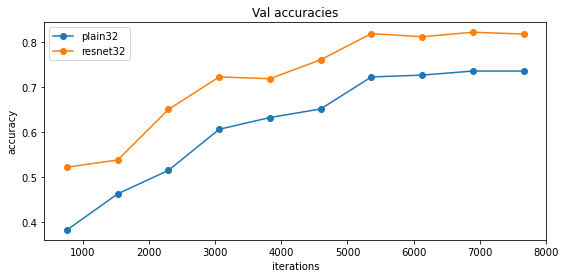

In [55]:
plt.title('Val accuracies')
for name in names:
  plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Residual bottleneck block

A bottleneck block is often useful for better efficiency, especially when importing a model to mobile devices.
The residual bottleneck block is similar to the standard residual block, but the plain block part has a different architecture:
it consists of 3 convolutional layers, and the first two convolutional layers have a smaller number of channels.

Here is the specification of the bottleneck block:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout // 4` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout // 4` 3x3 filters, with zero-padding of 1
7. Spatial Batch normalization
8. ReLU
9. Convolutional layer with `Cout` 1x1 filters

Implement `ResidualBottleneckBlock.__init__` and don't forget to add the residual connection!

In [59]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


By running the following script, you can check the architecture of ResNet-47 with bottlenecks.

Caution: it is long!

In [60]:
# example of specification
networks.update({
  'resnet47': {
    'block': ResidualBottleneckBlock,
    'stage_args': [
      (32, 32, 5, False),
      (32, 64, 5, True),
      (64, 128, 5, True),
    ],
  },
})

print(get_resnet('resnet47'))

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBottleneckBlock(
          (block): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (shortcut): Sequential(
            (0): Identity()
          )
        )
        (1): ResidualBottle

# Final checks
Make sure you run "Runtime -> Restart and run all..." to double check PyTorch Autograd and NN before submitting.

# Save results

Once all the cells are completed, save the loss history of all the parts for submission.

In [ ]:
acc_history_dict['acc_hist_part2'] = acc_hist_part2 
acc_history_dict['acc_hist_part3'] = acc_hist_part3 
acc_history_dict['acc_hist_part4'] = acc_hist_part4 
submission_path = os.path.join(GOOGLE_DRIVE_PATH, 'pytorch_autograd_and_nn.pkl')
dump_results(acc_history_dict, submission_path)